# Suivis des cas au Québec
16 avril, Luc Gauthier

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

FILTERED_REGIONS = [
    '18 - Terres-Cries-de-la-Baie-James',
    '10 - Nord-du-Québec',
    #'17 - Nunavik'
    #'01 - Bas-Saint-Laurent',
    #'08 - Abitibi-Temiscamingue'
    ]

%config InlineBackend.figure_format = 'retina'

### Mise en place

Chargement des données du Québec par région.

In [2]:
url = 'https://raw.githubusercontent.com/lucgauthier/covid-19-data/master/quebec-regions.csv'
regions = pd.read_csv(url,
                     usecols=[0,1,2],
                     index_col=['region', 'date'],
                     parse_dates=['date'],
                     squeeze=True).sort_index()

Lissage des données.

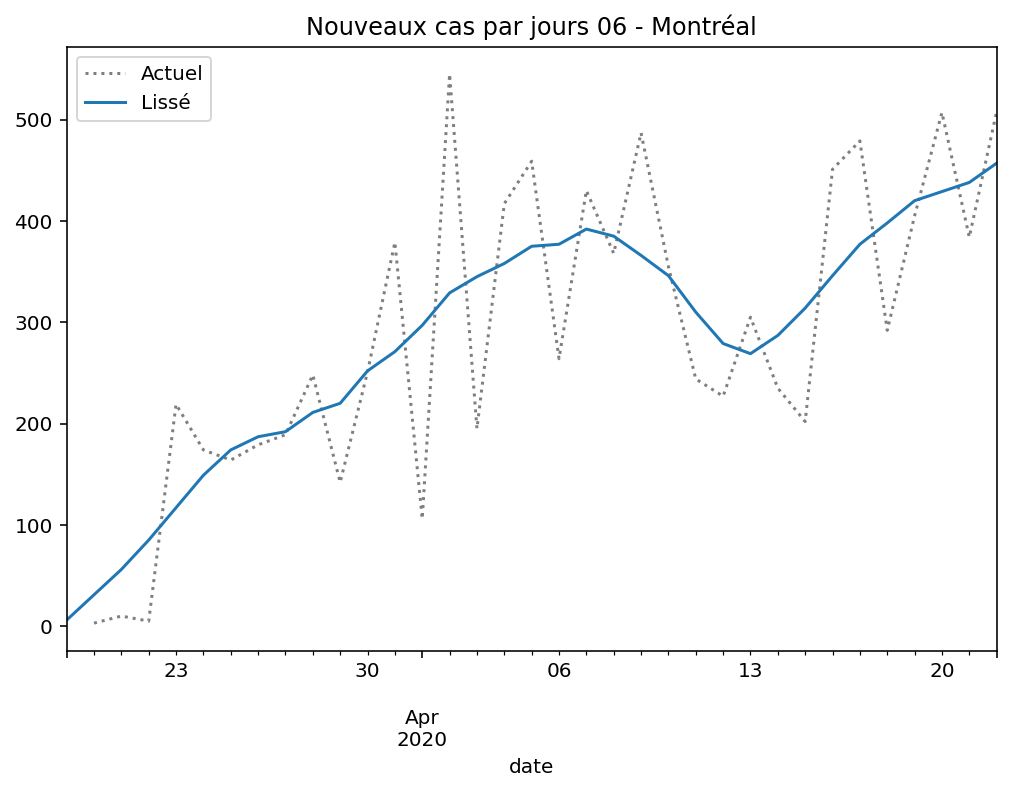

In [3]:
region_name = '06 - Montréal'

def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = regions.xs(region_name).rename(f"Cas de la région {region_name}")

original, smoothed = prepare_cases(cases)

original.plot(title=f"Nouveaux cas par jours {region_name}",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actuel',
               legend=True,
             figsize=(600/72, 400/72))

ax = smoothed.plot(label='Lissé',
                   legend=True)
ax.get_figure().set_facecolor('w')

### Nouveaux cas par région

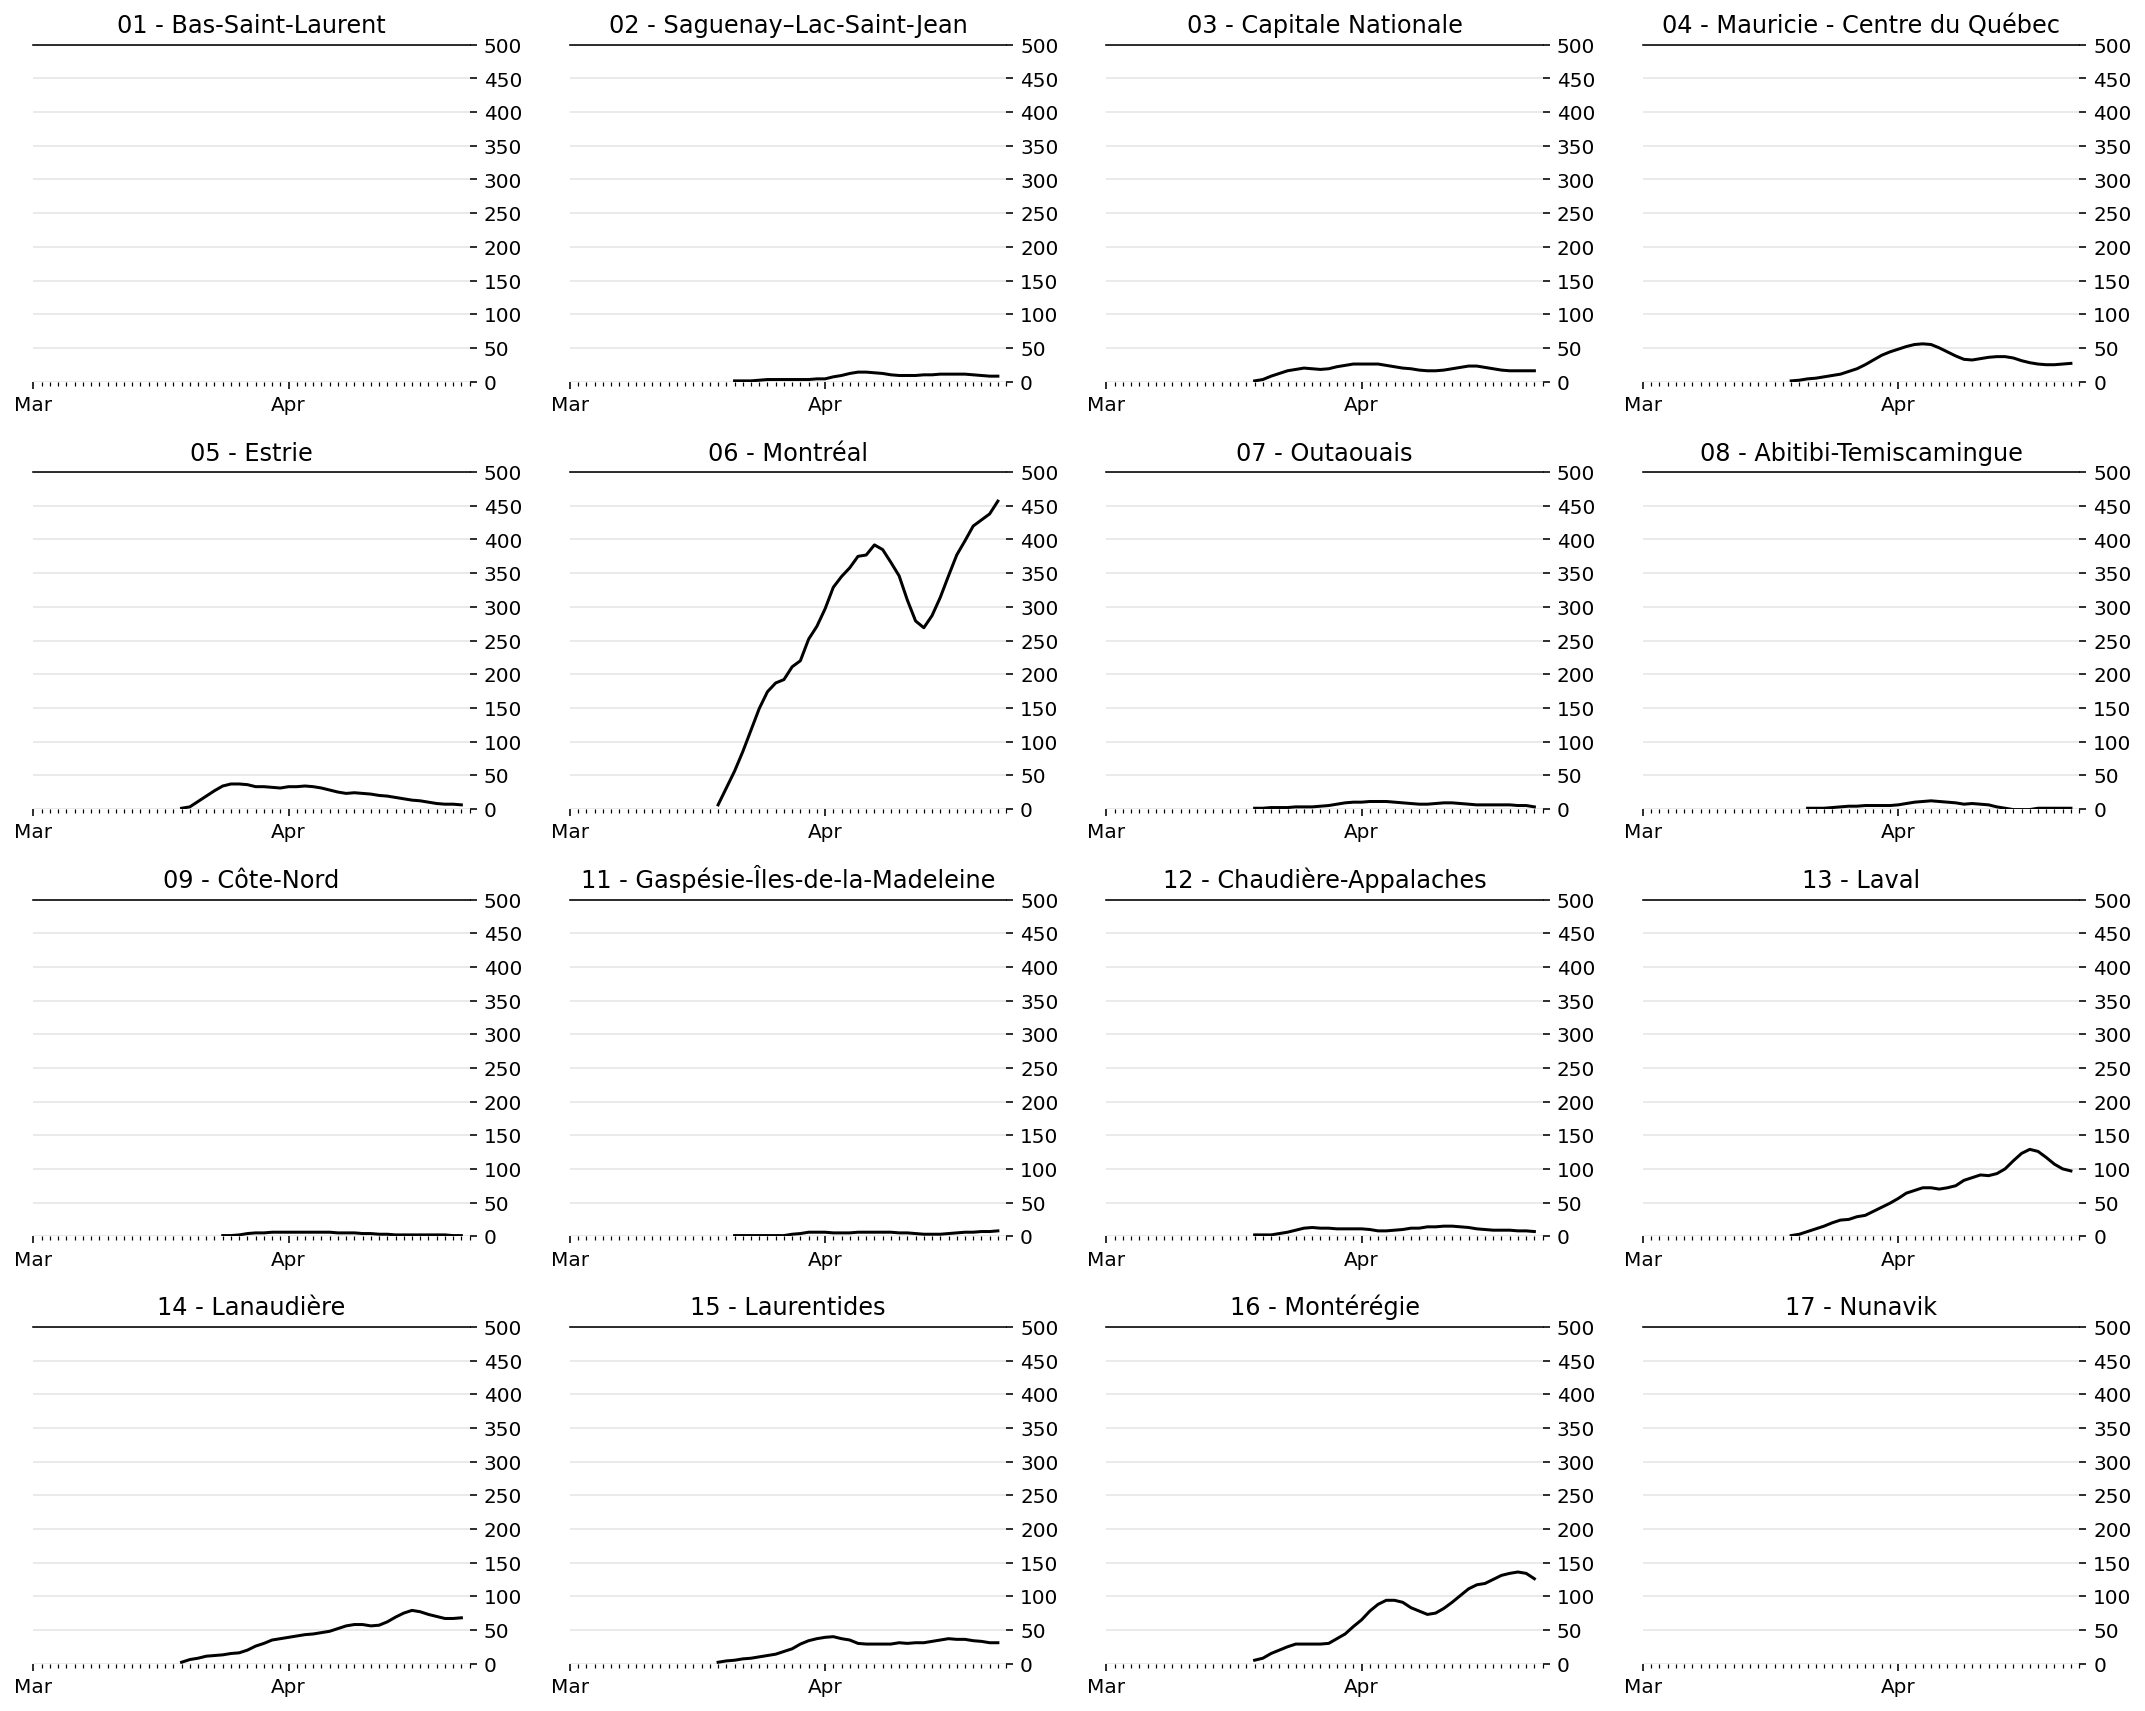

In [4]:
# Générer le graphique d'une région
def plot_region(result, ax, region_name, ymax, yinterval):
    
    ax.set_title(f"{region_name}")
    index = result['cases'].index.get_level_values('date')
    values = result['smoothed'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=1)
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(yinterval))
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.tick_right()
    
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, ymax)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

# Préparer les données
regions_to_process = regions.loc[~regions.index.get_level_values('region').isin(FILTERED_REGIONS)]

results = {}

for region_name, cases in regions_to_process.groupby(level='region'):
    new, smoothed = prepare_cases(cases)
    
    newCases = new.rename('new')
    smoothedCases = smoothed.rename('smoothed')
    
    result =  pd.concat([cases, newCases, smoothedCases], axis=1)
    results[region_name] = result.droplevel(0)

# Layout en 4 colonnes
ncols = 4
nrows = int(np.ceil(len(results) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (region_name, result) in enumerate(results.items()):
    plot_region(result, axes.flat[i], region_name, 500, 50)

fig.tight_layout()
fig.set_facecolor('w')

## Même graphiques, avec axe X bloqué à 200

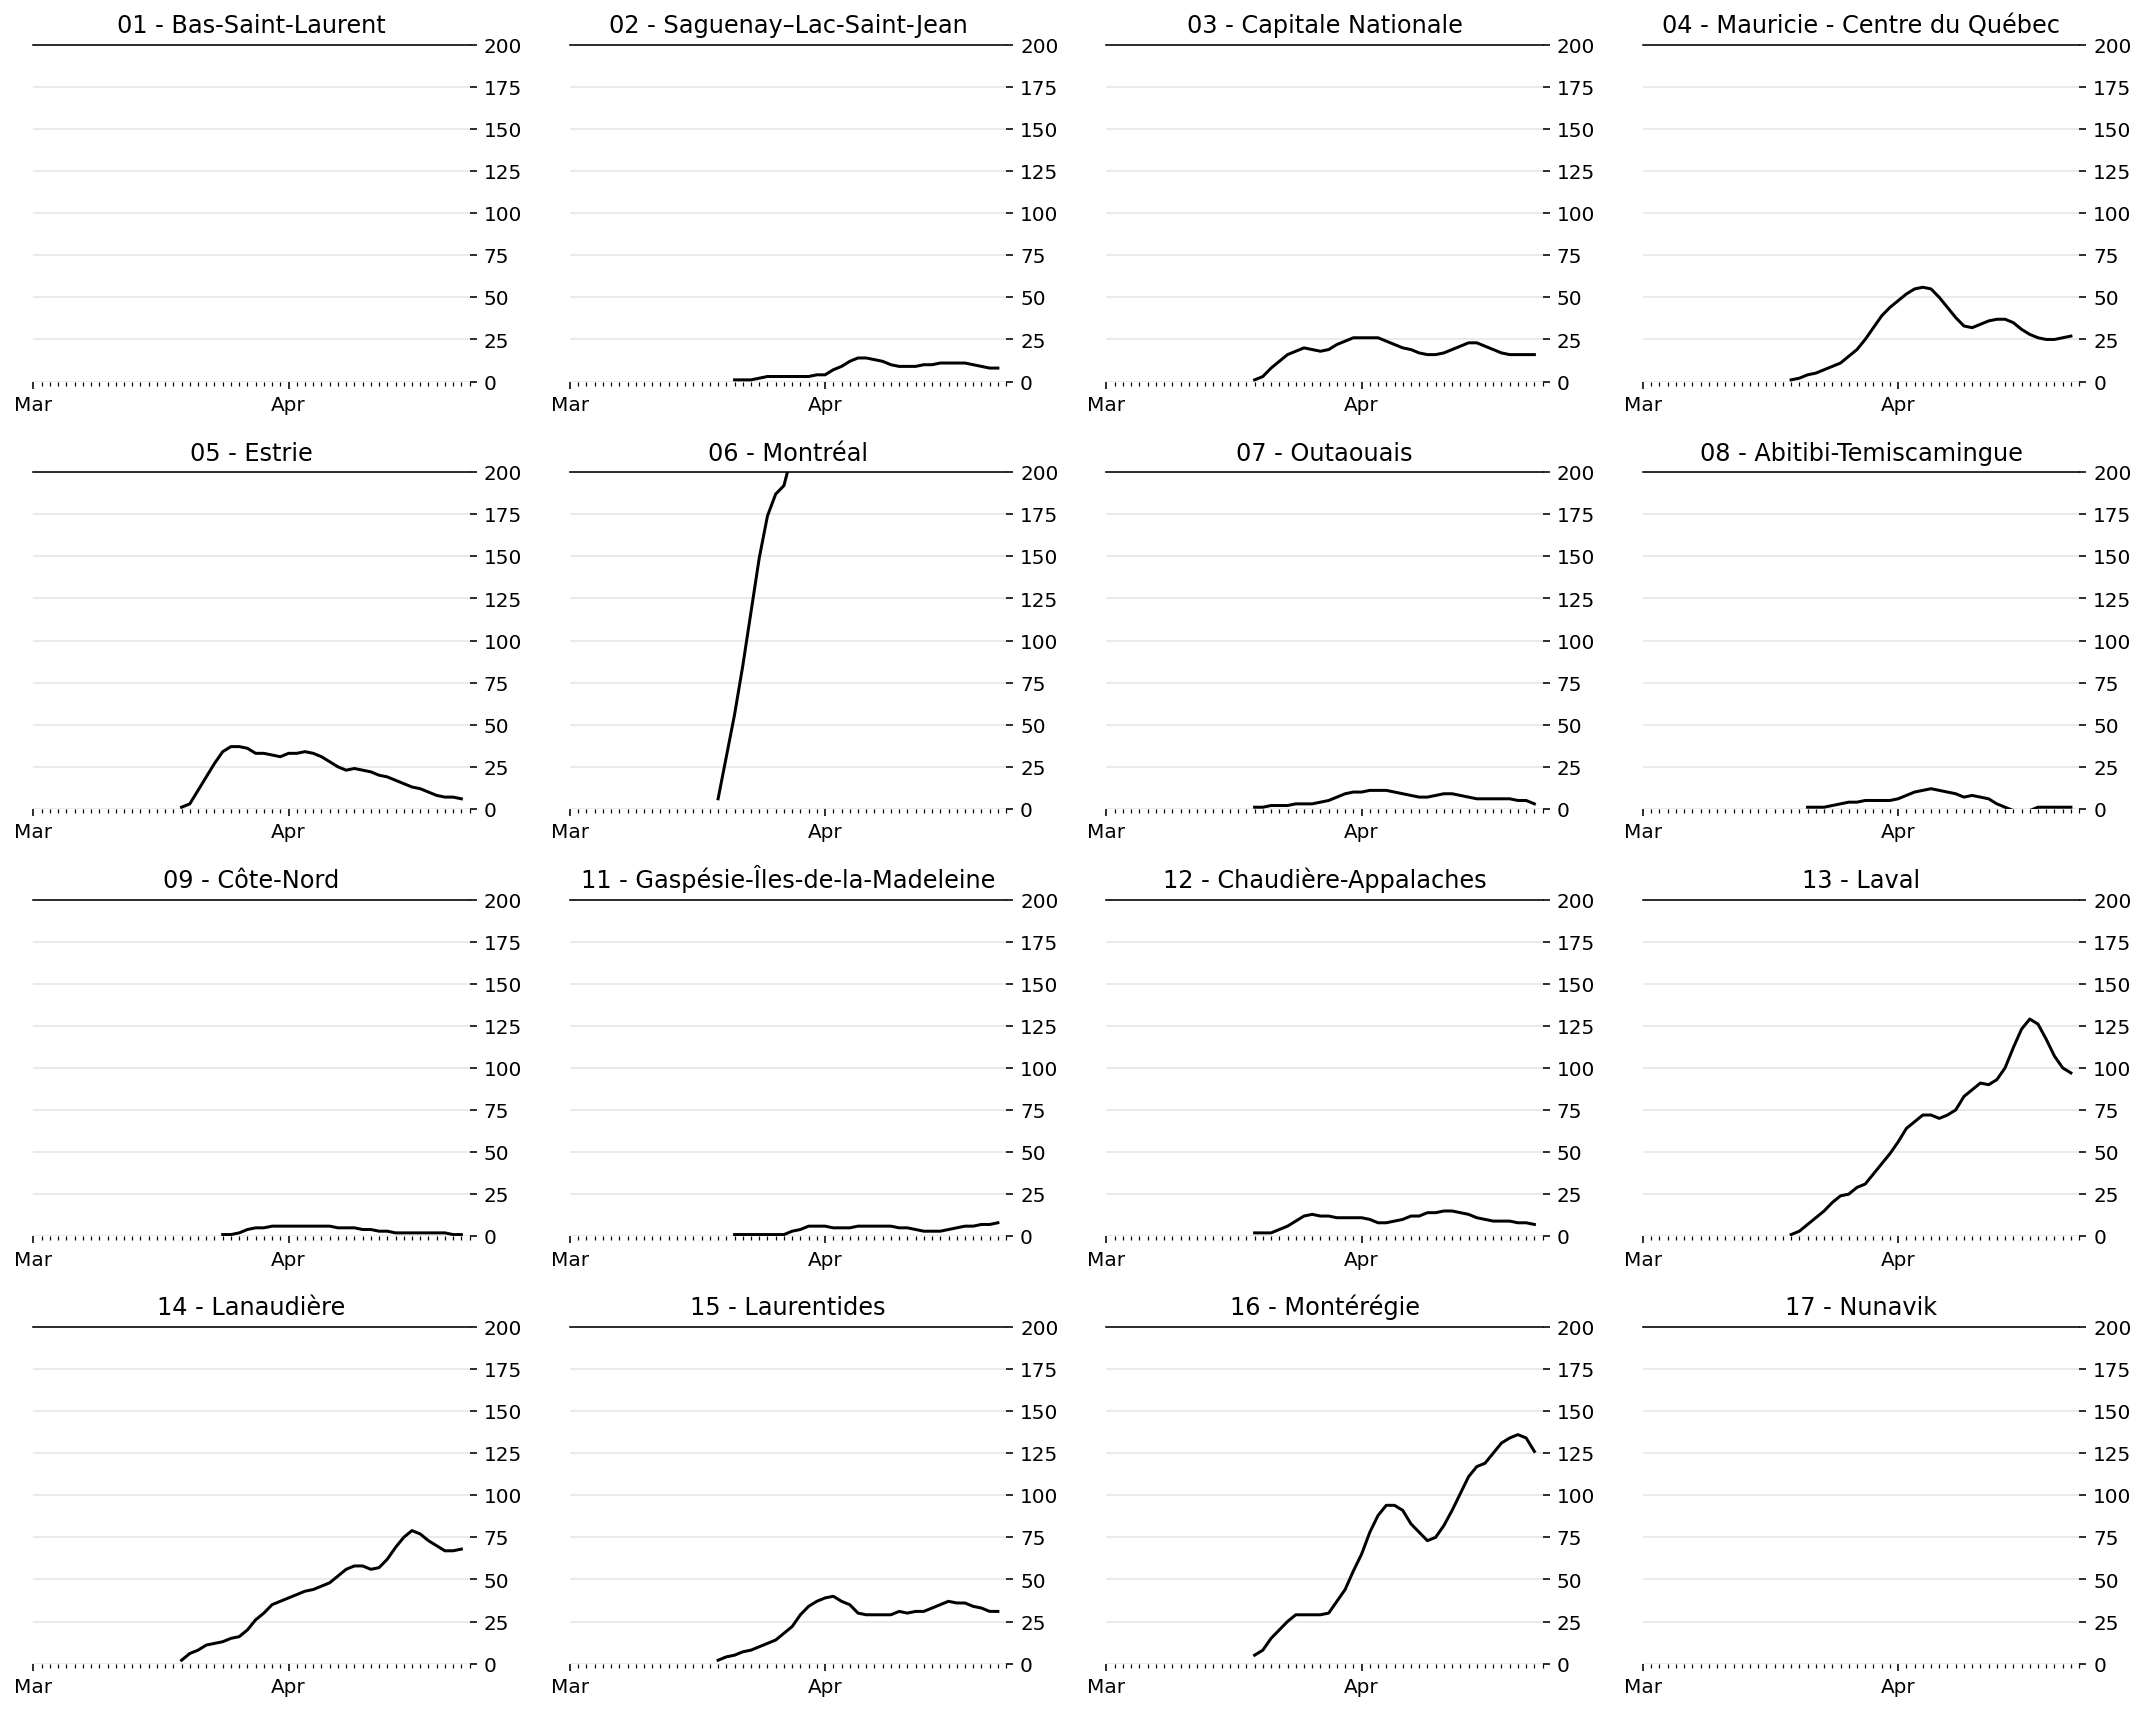

In [5]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (region_name, result) in enumerate(results.items()):
    plot_region(result, axes.flat[i], region_name, 200, 25)

fig.tight_layout()
fig.set_facecolor('w')